In [1]:
import numpy
import pandas
import scipy.misc, scipy.stats
import seaborn
import sys
from collections import defaultdict

seaborn.set_style("white")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Overview

I aligned the raw sequences to a single reference sequence representing the merged allele, with only shared sequence (see `ref.fa` and `commands.sh`):

    ATCTCTTTTCTTCTCTGTGCGAGGATTTGGACTGGCAGTG

I changed the SNP to a third base (`G`) so that neither allele would match it.

I used the CIGAR string from the read alignments to generate "mutation profiles" for each read, where `1` is a mutation and `0` is not.  I assign `?` if the read did not align in that position (see `sam_to_binary_counts.py`).  For example:

    0000000000000000100000000000000000000000
    0000000000000000100000000000000100000000
    0000000000000101100000000000000000000000
    0000000000000000100000000000000000000000
    000000000000000010000000001000??????????

I load those string mutation profiles below and cluster them based on vectors of mutation probabilities, which are learned simultaneously.

I only consider reads that have more than 2 mutations, in order to get reads that give useful joint information across positions (the masked SNP in the middle counts as 1).

The clustering procedure is fairly sensitive to the (random) initialization of the mutation probability vectors, so multiple restarts are needed.

After clustering finishes, I compare the predicted cluster membership probabilities with the assigned allele (see `sam_to_allele_labels.py`).

## Load file of bit vector representations

In [2]:
# load from full annotated file and do filtering here (and keep labels for downstream validation)
prefix = "/cluster/matted/ribosnitch_silvi"
annotated = pandas.read_csv(prefix + "/realigned_bitvectors.txt",
                            sep=" ",
                            names=["name", "bitvector", "mutations", "label"])

annotated = annotated[annotated["mutations"] > 2] # only consider reads with >2 mutations

x = []
for line in annotated["bitvector"].values:
    x.append(list(line.strip()))
x = pandas.DataFrame(numpy.asarray(x))
x.replace(["0", "1", "?"], [0.0, 1.0, numpy.nan], inplace=True)

mask = (x.notnull().mean(axis=1) > 0.9).values

x = x[mask]
annotated = annotated[mask]

print x.shape, annotated.shape

(20551, 40) (20551, 4)


In [3]:
# load allele labels that follow silvi's method
prefix = "/cluster/matted/ribosnitch_silvi/"
labels = pandas.read_csv(prefix + "OC57_index2_S2_L002_R1_001.strip.ribosmall.1mill.assigned.txt",
                            sep=" ",
                            names=["name", "silvi_label"])
try:
    del annotated["silvi_label"]
except KeyError:
    pass

print annotated.shape
annotated = pandas.merge(annotated, labels, left_on="name", right_on="name", how="left")
print annotated.shape
annotated.head(3)

(20551, 4)
(20551, 5)


,name,bitvector,mutations,label,silvi_label
0,K00153:60:H3HK3BBXX:2:1101:5507:1156,0000000000000101100000000000000000000000,3,A,A
1,K00153:60:H3HK3BBXX:2:1101:9100:1156,0000000001100000100000000000000000000000,3,C,C
2,K00153:60:H3HK3BBXX:2:1101:11353:1156,0001000000010000100000000000000000000000,3,A,A


In [4]:
annotated.groupby(["label", "silvi_label"])[["name"]].count()

name
label silvi_label       
A     ?                1
      A            14320
      C                4
C     ?                5
      A              345
      C             5432
G     A               14
      C                9
T     ?                5
      A              405
      C               11

In [5]:
# mark the column with the known SNP as missing, so that later plots are simpler
if len((x.mean(axis=0) > 0.5).nonzero()[0]) > 0:
    excluded_column = (x.mean(axis=0) > 0.5).nonzero()[0][0]
    x[excluded_column] = numpy.nan
    
# exclude columns that very rarely see mutations (probably just errors there)
if False:
    x[x.columns[(x.mean(axis=0) <= 0.01).values].values] = numpy.nan

In [6]:
# or just use simulated data (overwrites previously loaded stuff)
if False:
    n = 10000
    p = 3
    x = numpy.zeros((n, p))

    x[:2*n/3, 0] = scipy.stats.bernoulli.rvs(0.2, size=2*n/3)
    x[:2*n/3:, 1] = scipy.stats.bernoulli.rvs(0.8, size=2*n/3)
    x[:2*n/3:, 2] = scipy.stats.bernoulli.rvs(0.1, size=2*n/3)

    x[-n/3+1:, 0] = scipy.stats.bernoulli.rvs(0.8, size=n/3)
    x[-n/3+1:, 1] = scipy.stats.bernoulli.rvs(0.2, size=n/3)
    x[-n/3+1:, 2] = scipy.stats.bernoulli.rvs(0.7, size=n/3)

    x = pandas.DataFrame(x)

## Visualize the data

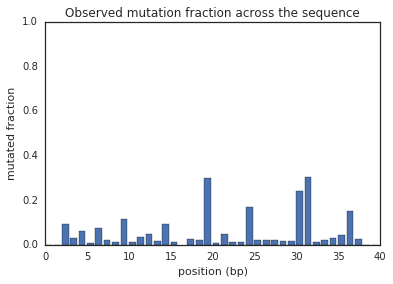

In [7]:
pylab.bar(x.columns.values, x.mean(axis=0))
pylab.ylim(0, 1)
pylab.ylabel("mutated fraction")
pylab.xlabel("position (bp)")
pylab.title("Observed mutation fraction across the sequence")
pylab.show()

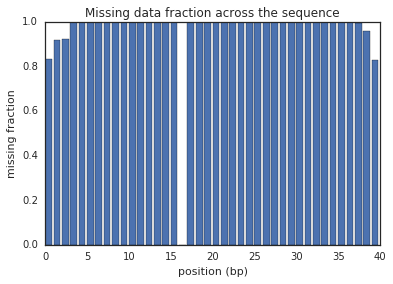

In [8]:
pylab.bar(x.columns.values, x.notnull().mean(axis=0))
pylab.ylim(0, 1)
pylab.ylabel("missing fraction")
pylab.xlabel("position (bp)")
pylab.title("Missing data fraction across the sequence")
pylab.show()

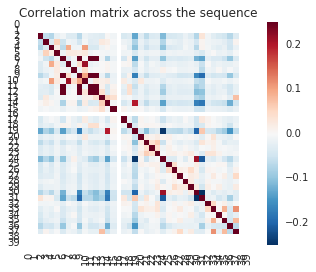

In [9]:
seaborn.heatmap(x.corr(), square=True, vmax=0.25, vmin=-0.25)
pylab.title("Correlation matrix across the sequence")
pylab.show()

## Cluster the reads by per-base mutation frequency

This is (multivariate) Bernoulli mixture model clustering via expectation maximization (EM).

See this writeup for a good overview: https://nsgrantham.github.io/documents/clustering-binary-data.pdf.

In [10]:
def binary_loglik(observed, probs):
    lik = scipy.stats.bernoulli.logpmf(observed, probs)
    # ignore nan values
    lik = lik[numpy.isfinite(lik)]
    return numpy.sum(lik)

In [11]:
p = x.shape[1]
n = x.shape[0]
d = 3 # number of clusters

# prior for per-base mutation frequencies when re-estimating from observed data
# interpretation is positive (mutated) and negative (non-mutated) pseudo-counts
# 0.0 for both means we're just doing MLE instead of MAP
a = 0.0
b = 0.0

max_its = 20 # how many EM rounds to run
verbose = False # print more output and intermediate plots?

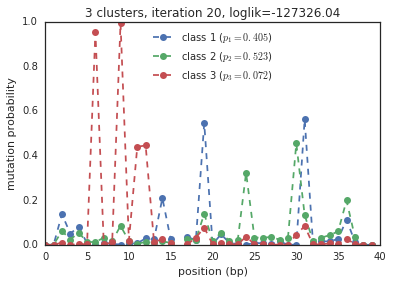

In [12]:
# clusters = [scipy.stats.uniform.rvs(0, 1, size=p) for i in xrange(d)]
clusters = [scipy.stats.beta.rvs(2, 2, size=p) for i in xrange(d)]
cluster_probs = numpy.asarray([1.0/d] * d)

responsibilities = numpy.zeros((n, d))

last_loglik = -numpy.inf

for its in xrange(max_its):
    ### (probabilistically) assign reads to clusters
    loglik = 0.0
    for i in xrange(n):
        if i % 10000 == 0 and verbose: print >>sys.stderr, i
        for j in xrange(d):
            responsibilities[i, j] = numpy.log(cluster_probs[j]) + binary_loglik(x.iloc[i].values, clusters[j])
        # normalize the class responsibilities for this read:
        # responsibilities[i, :] -= numpy.log(numpy.sum(numpy.exp(responsibilities[i, :]))) 
        # numerically stable version:
        temp = scipy.misc.logsumexp(responsibilities[i, :])
        loglik += temp
        responsibilities[i, :] -= temp

    responsibilities = numpy.exp(responsibilities)
    cluster_probs = numpy.nanmean(responsibilities, axis=0)
    
    ### re-estimate cluster parameters
    for j in xrange(d):
        for k in xrange(p):
            clusters[j][k] = ((a + numpy.nansum(responsibilities[:, j] * x.values[:, k])) / 
                              (a + b + numpy.nansum(responsibilities[:, j] * numpy.isfinite(x.values[:, k]))))

    ### visualize cluster parameters at each iteration
    if verbose or its + 1 == max_its:
        for j in xrange(d):
            pylab.plot(x.columns.values, clusters[j], 'o--', 
                       label="class %d ($p_%d=%.3f$)" % (j+1, j+1, cluster_probs[j], ))
        pylab.ylim(0, 1)
        pylab.ylabel("mutation probability")
        pylab.xlabel("position (bp)")    
        pylab.legend(loc="upper center")
        pylab.title("%d clusters, iteration %d, loglik=%.2f" % (d, its+1, loglik))
        pylab.show()
    
    # if the likelihood has converged (locally), stop iterating
    if numpy.abs(loglik - last_loglik) < 0.01:
        break
    last_loglik = loglik

## Visualize the final clusters and read assignments

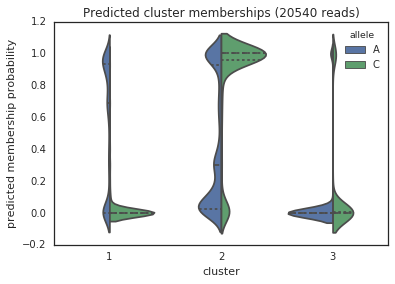

In [13]:
# exclude reads that we couldn't label successfully
mask = (annotated["silvi_label"] != "?").values # & (annotated["silvi_label"] == annotated["label"]).values

prob_label = "predicted membership probability"

combined = defaultdict(list)
for j in xrange(d):
    combined["allele"].extend(annotated["silvi_label"].values[mask])
    combined[prob_label].extend(responsibilities[:,j][mask])
    combined["cluster"].extend([str(j+1)]*mask.sum())
    
combined = pandas.DataFrame(combined)

seaborn.violinplot(y=prob_label, x="cluster", hue="allele", split=True, inner="quartile", data=combined)
pylab.title("Predicted cluster memberships (%d reads)" % mask.sum())
pylab.show()

# combined.tail()

In [14]:
temp = annotated[["name", "silvi_label", "label"]].copy()
predicted_cluster = []

for i in xrange(n):
    predicted_cluster.append(responsibilities[i, :].argmax() + 1)

temp["predicted_cluster"] = predicted_cluster
temp.groupby(["silvi_label", "predicted_cluster"]).count()[["name"]]

name
silvi_label predicted_cluster      
?           1                     1
            2                     3
            3                     7
A           1                  8821
            2                  5567
            3                   696
C           1                   170
            2                  4534
            3                   752

## Random extra plots for testing

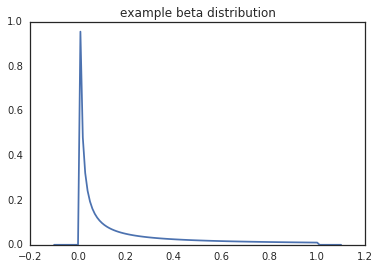

In [15]:
xvals = numpy.arange(-0.1, 1.1, 0.01)
pylab.plot(xvals, scipy.stats.beta.pdf(xvals, 1e-2, 1.0))
pylab.title("example beta distribution")
pylab.show()